# A Pleasent Flight
 Historical Air Crash + Delay Investigation

Unfortunely, there were many aviation accidents that caused innocent people to perish. While lessons we learnt in the past tragedy have made flying now more and more safer, the figures of planes falling from the sky still frightens a few people from having a pleasent flight. In this data analysis, we are going persuade thoes who are afraid by to investigate how safe are planes and, if one is still concerned, how to maximize one's safety? To make our report also interesting to general public, we will also investigate how one can minimize delays. 

In [1]:
import pandas as pd
import numpy as np
from numpy import nan as Nan
import matplotlib.pyplot as plt
import requests
from string import digits
import wget # you need to "pip install wget"  
import glob
import time

import plotly.graph_objects as go
import pandas as pd
import plotly.figure_factory as ff
import xml.etree.ElementTree as ET # to read one dataset in XML format

## Clean Air Crash Data

In [2]:
crash_df = pd.read_csv("datasets/crash/Airplane_Crashes_and_Fatalities_Since_1908.csv")
etree = ET.parse("datasets/crash/AviationData.xml")



In [3]:
xml_root = etree.getroot()

interest_columns = ["EventId","EventDate","Location","Country","Latitude","Longitude","AirportCode","InjurySeverity","AircraftDamage",
                    "AircraftCategory","NumberOfEngines","EngineType","Schedule","TotalUninjured","TotalMinorInjuries",
                    "TotalSeriousInjuries","TotalFatalInjuries","WeatherCondition","BroadPhaseOfFlight","RegistrationNumber","PurposeOfFlight"]

NTSB_crash_df = pd.DataFrame(columns=interest_columns)

for elem in xml_root: # This loop will run only once
    for row in elem: 
        if not(row.attrib["PurposeOfFlight"]=="Business"):
            continue
        information = list()
        for interest in interest_columns:
            if not (row.attrib[interest]==""):
                information.append(row.attrib[interest])
            else:
                information.append(Nan)
        row_information = pd.Series(information,index=interest_columns)
        NTSB_crash_df = NTSB_crash_df.append(row_information,ignore_index=True)
            
# this may need to run for a while. It takes 18 seconds on my computer
    

In [4]:
NTSB_crash_df[(NTSB_crash_df["AircraftCategory"]=="Airplane") & (NTSB_crash_df["EngineType"]!="Reciprocating") & (NTSB_crash_df["Country"]=="United States")]

EventId   EventDate           Location        Country   Latitude  \
2     20191031X31506  10/31/2019  New Braunfels, TX  United States  29.705833   
6     20191021X62154  10/16/2019        Augusta, GA  United States  33.371945   
7     20191005X82852  10/05/2019         Kokomo, IN  United States  40.475000   
8     20191003X13056  10/03/2019        Lansing, MI  United States  42.780278   
10    20190829X34852  08/29/2019          Olney, TX  United States  33.350833   
...              ...         ...                ...            ...        ...   
3887  20020917X01697  04/07/1982  WINSTON-SALEM, NC  United States        NaN   
3905  20020917X02057  03/23/1982         CONROE, TX  United States        NaN   
3915  20020917X02196  03/12/1982          CHINO, CA  United States        NaN   
3936  20020917X01727  02/16/1982    SPRINGFIELD, KY  United States        NaN   
3946  20020917X01923  02/03/1982         HAYDEN, CO  United States        NaN   

       Longitude AirportCode InjurySeverity AircraftDamage AircraftCategory  \
2     -98.043333         BAZ      Non-Fatal          Minor         Airplane   
6     -81.971667         AGS      Non-Fatal            NaN         Airplane   
7     -86.063333         OKK       Fatal(1)      Destroyed         Airplane   
8     -84.606111         LAN       Fatal(5)    Substantial         Airplane   
10    -98.819167         ONY      Non-Fatal    Substantial         Airplane   
...          ...         ...            ...            ...              ...   
3887         NaN         INT      Non-Fatal    Substantial         Airplane   
3905         NaN         CXO      Non-Fatal    Substantial         Airplane   
3915         NaN         CNO      Non-Fatal    Substantial         Airplane   
3936         NaN         6I2       Fatal(8)      Destroyed         Airplane   
3946         NaN         HDN      Non-Fatal      Destroyed         Airplane   

      ...  EngineType Schedule TotalUninjured TotalMinorInjuries  \
2     ...         NaN      NaN              1                NaN   
6     ...   Turbo Fan      NaN            NaN                NaN   
7     ...         NaN      NaN            NaN                NaN   
8     ...  Turbo Prop      NaN            NaN                NaN   
10    ...  Turbo Prop      NaN            NaN                  1   
...   ...         ...      ...            ...                ...   
3887  ...  Turbo Prop      NaN              2                  0   
3905  ...  Turbo Prop      NaN              3                  0   
3915  ...   Turbo Jet      NaN              2                  0   
3936  ...  Turbo Prop      NaN              0                  0   
3946  ...  Turbo Prop      NaN              0                  6   

     TotalSeriousInjuries TotalFatalInjuries WeatherCondition  \
2                       1                NaN              VMC   
6                       1                NaN              VMC   
7                     NaN                  1              VMC   
8                       1                  5              IMC   
10                    NaN                NaN              VMC   
...                   ...                ...              ...   
3887                    0                  0              VMC   
3905                    0                  0              IMC   
3915                    0                  0              VMC   
3936                    0                  8              IMC   
3946                    0                  0              IMC   

     BroadPhaseOfFlight RegistrationNumber PurposeOfFlight  
2                   NaN             N850BK        Business  
6                  TAXI             N307KP        Business  
7           MANEUVERING             N326CW        Business  
8              APPROACH             N700AQ        Business  
10              TAKEOFF             N8517Q        Business  
...                 ...                ...             ...  
3887            LANDING              N7377        Business  
3905 

## Clean Flight Delay Data

In [5]:

use_storage = False
have_storage = True

try:
    pd.read_csv("processed/unpleasant_2009.csv")
except:
    have_storage = False

if not(use_storage and have_storage):
    delay_2009_df = pd.read_csv("datasets/delay/2009.csv")
    # DEPARTURE
    unpleasant_2009_departure = pd.DataFrame()
    unpleasant_2009_departure['total_departure'] = delay_2009_df.loc[:,["ORIGIN"]].groupby('ORIGIN').size()
    unpleasant_2009_departure[["average_departure_delay","average_departure_taxi"]] = delay_2009_df.loc[:,["ORIGIN","DEP_DELAY","TAXI_OUT"]].groupby('ORIGIN').mean()
    unpleasant_2009_departure['average_departure_cancelled'] = delay_2009_df.loc[:,["ORIGIN","CANCELLED"]].groupby('ORIGIN').mean()
    unpleasant_2009_departure['averge_departure_distance'] = delay_2009_df.loc[:,["ORIGIN","DISTANCE"]].groupby('ORIGIN').mean()
    #ARRIVAL
    unpleasant_2009_arrival = pd.DataFrame()
    unpleasant_2009_arrival['total_arrival'] = delay_2009_df.loc[:,["DEST"]].groupby('DEST').size()
    unpleasant_2009_arrival[["average_arrival_delay","average_arrival_taxi"]] = delay_2009_df.loc[:,["DEST","ARR_DELAY","TAXI_IN"]].groupby('DEST').mean()
    unpleasant_2009_arrival['average_arrival_diverted'] = delay_2009_df.loc[:,["DEST","DIVERTED"]].groupby('DEST').mean()
    unpleasant_2009_arrival['averge_arrival_distance'] = delay_2009_df.loc[:,["DEST","DISTANCE"]].groupby('DEST').mean()
    
    unpleasant_2009_departure['total_departure_lg10'] = unpleasant_2009_departure['total_departure'].apply(np.log10)
    unpleasant_2009_arrival['total_arrival_lg10'] = unpleasant_2009_arrival['total_arrival'].apply(np.log10)

    unpleasant_2009 = unpleasant_2009_departure.merge(unpleasant_2009_arrival,left_index=True,right_index=True)
    unpleasant_2009.to_csv("processed/unpleasant_2009.csv")
else:
    unpleasant_2009 = pd.read_csv("processed/unpleasant_2009.csv")

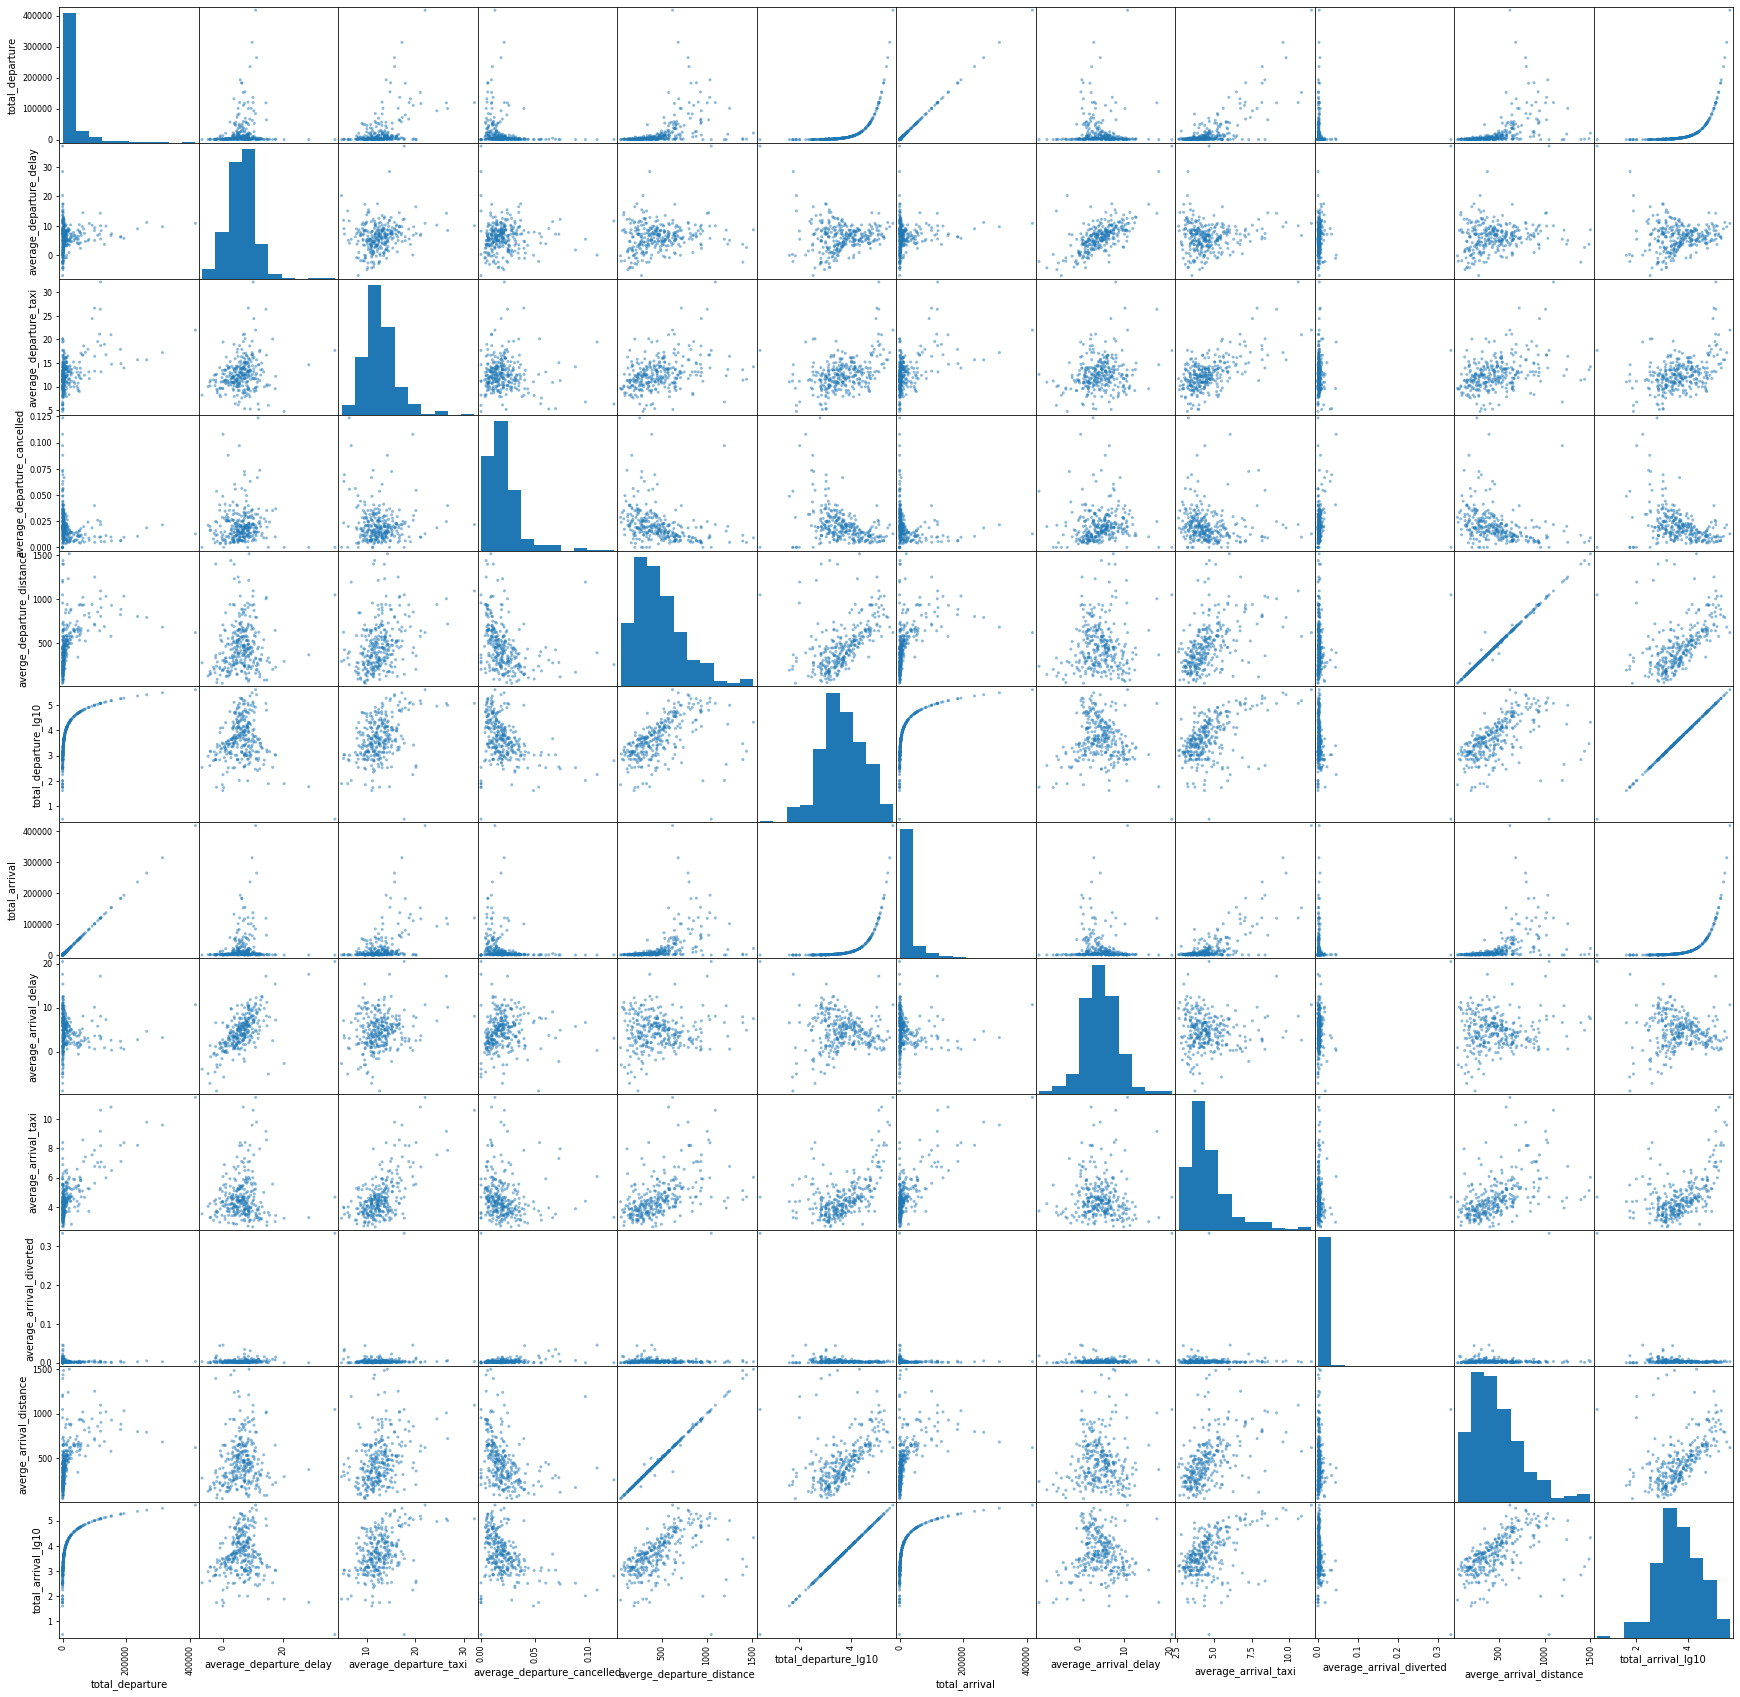

In [6]:
pd.plotting.scatter_matrix(unpleasant_2009,figsize=(30,30))
plt.savefig("test.png")

## Clean Airport Data

In [7]:
df_airport = pd.read_csv("datasets/airports/airports-extended.csv") #https://www.kaggle.com/open-flights/airports-train-stations-and-ferry-terminals#airports-extended.csv
df_airport.columns = ["ID","name","city","country","code","code4","latitude","longitude","altitude_ft","UTC_offset","DST","timezone","type","information_source"]
df_airport = df_airport.loc[:,["city","country","code","latitude","longitude","altitude_ft"]]
df_airport = df_airport[df_airport["country"]=="United States"]
df_airport = df_airport.loc[:,["city","code","latitude","longitude","altitude_ft"]]
df_airport = df_airport[df_airport["code"]!="\\N"] # remove NAN in index
df_airport = df_airport.set_index("code")

#clean city name
def clean_city_name(input_city):
    original = input_city
    input_city = str(input_city)
    input_city = input_city.strip()
    input_city = input_city.lower()
    
    input_city = input_city.replace(".","")
    input_city = input_city.replace("\\\\","")
    input_city = input_city.replace("-"," ")
    input_city = input_city.replace(" - "," ")
    input_city = input_city.replace("saint ","st")
    input_city = input_city.replace("east ","")
    input_city = input_city.replace("west ","")
    
    input_city = input_city.translate({ord(k): None for k in digits})
    
    if ('/' in input_city):
        input_city = input_city[:input_city.find('/')]
    if ('(' in input_city):
        input_city = input_city[:input_city.find('(')]
    if (',' in input_city):
        input_city = input_city[:input_city.find(',')]
    input_city = input_city.strip()   
    if (' ' in input_city):
        temp=input_city.find(' ')
        if (temp > 2):
            input_city = input_city[:input_city.find(' ')]
        else:
            if (input_city.find(' ',temp+1) != -1):
                input_city = input_city[temp+1:input_city.find(' ',temp+1)]
            else:
                input_city = input_city[temp+1:]
    input_city = input_city.strip()
    try:
        assert len(input_city) > 2
        assert input_city.replace(" ","").replace("'","").isalpha()
    except:
        print("This city name is prehaps incorrect: ",original,input_city,len(original))
    return input_city

df_airport["city"] = df_airport["city"].apply(clean_city_name)



## Clean city climate dataset

### 1. Match airport with county information

In [8]:
us_cities_df = pd.read_csv("datasets/city/uscities.csv")

us_cities_df = us_cities_df[["city","state_id","county_fips","county_name","population","density","lat","lng"]]
us_cities_df["fips"] = us_cities_df["county_fips"]

airport_prop_df = unpleasant_2009.merge(df_airport,how='inner',left_index=True,right_index=True)

def get_county_code(input_county):
    return int(input_county) % 1000

us_cities_df["county_fips"] = us_cities_df["county_fips"].apply(get_county_code)

us_cities_df["city"] = us_cities_df["city"].apply(clean_city_name)


city_climate_df = pd.DataFrame(columns=["code","population","density","avg_temp_sp","avg_temp_su","avg_temp_fa","avg_temp_wi","avg_precipitation_sp","avg_precipitation_su","avg_precipitation_fa","avg_precipitation_wi"])
city_search_df = pd.DataFrame(columns=["code","state_id","county_id","city_id","fips"])
for ind,row in airport_prop_df.iterrows():
    city = row["city"]
    target_lat = row["latitude"]
    target_lng = row["longitude"]
    try:      
        target_cities = us_cities_df[us_cities_df["city"]==city]
        
        if not (target_cities.shape[0] == 1):
            def calc_dis(input_):
                err = abs(target_lat - input_["lat"]) + abs(target_lng - input_["lng"])
                return err
            target_cities.loc[:,"error"] = (target_cities.apply(calc_dis,axis=1))
            target_city = target_cities.sort_values(by="error").iloc[0]
            
            assert target_city["error"] < 1.5
            
            target_city = target_city.drop(["error"])
        elif (target_cities.shape[0] >= 1):
            target_city = target_cities.iloc[0]
        
        county = str(target_city["county_fips"])
        if (len(county)==1):
            county = "00" + county
        elif (len(county)==2):
            county = "0" + county

        city_search_df = city_search_df.append({"code":ind,"state_id":target_city["state_id"],"county_id":county,"city_id":target_city.name,"fips":target_city["fips"]},ignore_index=True)        
    except:
        try:
            def calc_dis(input_):
                err = abs(target_lat - input_["lat"]) + abs(target_lng - input_["lng"])
                return err
            us_cities_df_copy = us_cities_df
            us_cities_df_copy.loc[:,"error"] = (us_cities_df.apply(calc_dis,axis=1))
            target_city = us_cities_df_copy.sort_values(by="error").iloc[0]
            assert target_city["error"] < 1.5
            county = str(target_city["county_fips"])
            if (len(county)==1):
                county = "00" + county
            elif (len(county)==2):
                county = "0" + county
            city_search_df = city_search_df.append({"code":ind,"state_id":target_city["state_id"],"county_id":county,"city_id":target_city.name,"fips":target_city["fips"]},ignore_index=True)
        except:
            print("No data for ",city)
            city_search_df = city_search_df.append({"code":ind,"state_id":np.nan,"county_id":np.nan,"city_id":np.nan,"fips":np.nan},ignore_index=True)

#special case for DC
for ind,row in city_search_df.iterrows():
    if (row["code"]=="DCA"):
        city_search_df.iloc[ind]["state_id"]="MD"
        city_search_df.iloc[ind]["county_id"]="511"

        
        
city_search_df = city_search_df[(city_search_df["state_id"]!="HI") & (city_search_df["state_id"]!="AK")]
        
city_search_df.head()

This city name is prehaps incorrect:  Y-O Ranch o 9
This city name is prehaps incorrect:  Ho-Ho-Kus ho 9
This city name is prehaps incorrect:  St. Jo jo 6
This city name is prehaps incorrect:  Ty Ty ty 5
This city name is prehaps incorrect:  So-Hi hi 5
This city name is prehaps incorrect:  K. I. Sawyer i 12
This city name is prehaps incorrect:  G. L. García l 12


code state_id county_id city_id   fips
0  ABE       PA       077   10988  42077
1  ABI       TX       441    5333  48441
2  ABQ       NM       001    3742  35001
3  ABY       GA       095   17309  13095
4  ACK       MA       019   19193  25019

### 2. Scrape these cities (counties)

In [9]:
def download_climate_data(state,county,year):
    save_path = "datasets/weather/"
    fname = state + county + "_" + str(year) + ".csv"
    if (len(glob.glob(save_path + fname))==0):
        URL = "https://www.ncdc.noaa.gov/cag/county/time-series/{}-{}-{}-all-1-2000-2020.csv?base_prd=true&begbaseyear=1901&endbaseyear=2000".format(state,county,"tavg")
        r = requests.get(URL)
        file = wget.download(URL,out=save_path + "tavg/tavg_" + fname)
        URL = "https://www.ncdc.noaa.gov/cag/county/time-series/{}-{}-{}-all-1-2000-2020.csv?base_prd=true&begbaseyear=1901&endbaseyear=2000".format(state,county,"pcp")
        r = requests.get(URL)
        file = wget.download(URL,out=save_path + "pcp/pcp_" + fname)

        df_tavg = pd.read_csv(save_path + "tavg/tavg_" + fname).iloc[4:]
        df_tavg.columns=["date","tavg","comp"]
        tavg = df_tavg.set_index("date")["tavg"]

        df_pcp = pd.read_csv(save_path + "pcp/pcp_" + fname).iloc[4:]
        df_pcp.columns=["date","pcp","comp"]
        pcp = df_pcp.set_index("date")["pcp"]

        pd.concat([tavg, pcp], axis=1).to_csv(save_path + fname)
        time.sleep(1) # not requesting too frequently

counter = 0
for ind,row in city_search_df.iterrows():
    try:
        download_climate_data(row["state_id"],row["county_id"],2018)
        download_climate_data(row["state_id"],row["county_id"],2019)
    except:
        print(row)
    counter+=1
    print("progress: {:.2f}%   Just done: {}".format(100 * counter / city_search_df.shape[0],row["code"]),end="\r")


temp_pcp_df = pd.DataFrame(columns=["code","temp_avg","pcp_avg"])
for ind,row in city_search_df.iterrows():
    state = row["state_id"]
    county = row["county_id"]
    save_path = "datasets/weather/"
    years = [2018,2019]
    
    try:
        tavg = 0
        pcp = 0
        for year in years:
            fname = state + county + "_" + str(year) + ".csv"
            temp_pcp = pd.read_csv(save_path + fname)
            tavg += temp_pcp.mean()["tavg"]
            pcp += temp_pcp.mean()["pcp"]
        tavg /= len(years)
        pcp /= len(years)
        
        temp_pcp_df = temp_pcp_df.append({"code":row["code"],"temp_avg":tavg,"pcp_avg":pcp},ignore_index=True)
        
    except:
        temp_pcp_df = temp_pcp_df.append({"code":row["code"],"temp_avg":np.nan,"pcp_avg":np.nan},ignore_index=True)



In [10]:
airport_prop_df = airport_prop_df.merge(city_search_df.set_index("code").loc[:,["city_id","fips"]],left_index=True,right_index=True)
airport_prop_df = airport_prop_df.merge(temp_pcp_df.set_index("code"),left_index=True,right_index=True)

In [11]:
airport_prop_df

total_departure  average_departure_delay  average_departure_taxi  \
ABE             4034                 5.877463               13.556651   
ABI             2490                 8.685573                8.305099   
ABQ            35582                 5.050531                9.963724   
ABY              995                 7.742564               10.823409   
ACK              342                16.478788               20.081818   
..               ...                      ...                     ...   
VLD             1046                 9.388510               12.179337   
VPS             6959                 9.846379               14.439794   
WYS              340                -6.779412                8.191176   
XNA            13755                 7.796676               13.595218   
YUM             3194                -0.096876               13.423295   

     average_departure_cancelled  averge_departure_distance  \
ABE                     0.020327                 562.069658   
ABI                     0.023293                 158.000000   
ABQ                     0.005312                 641.429965   
ABY                     0.021106                 146.000000   
ACK                     0.035088                 199.000000   
..                           ...                        ...   
VLD                     0.019120                 208.000000   
VPS                     0.021555                 410.532117   
WYS                     0.000000                 273.000000   
XNA                     0.029953                 526.853435   
YUM                     0.008140                 182.846587   

     total_departure_lg10  total_arrival  average_arrival_delay  \
ABE              3.605736           4037               5.126924   
ABI              3.396199           2490              10.406404   
ABQ              4.551230          35577               2.210595   
ABY              2.997823            997               6.965271   
ACK              2.534026            343               2.516616   
..                    ...            ...                    ...   
VLD              3.019532           1046               9.211914   
VPS              3.842547           6958               9.355771   
WYS              2.531479            340              -3.958702   
XNA              4.138461          13764               6.735768   
YUM              3.504335           3193               0.067781   

     average_arrival_taxi  average_arrival_diverted  averge_arrival_distance  \
ABE              4.179300                  0.002973               561.860045   
ABI              3.518443                  0.001606               158.000000   
ABQ              5.242186                  0.000675               642.158726   
ABY              3.421859                  0.002006               146.000000   
ACK              5.556886                  0.008746               198.647230   
..                    ...                       ...                      ...   
VLD              3.992210                  0.003824               208.000000   
VPS              6.429512                  0.003593               410.595142   
WYS              3.523529                  0.002941               273.000000   
XNA              4.960809                  0.005522               527.071563   
YUM              5.054471                  0.001879               182.885687   

     total_arrival_lg10         city   latitude   longitude  altitude_ft  \
ABE            3.606059    allentown  40.652100  -75.440804          393   
ABI            3.396199      abilene  32.411301  -99.681900         1791   
ABQ            4.551169  albuquerque  35.040199 -106.609001         5355   
ABY            2.998695       albany  31.535500  -84.194504          197   
ACK            2.535294    nantucket  41.253101  -70.060204           47   
..                  ...          ...        ...         ...          ...   
VLD            3.019532     valdosta  30.782499  -83.276703          203 

In [12]:
colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]
values = airport_prop_df['pcp_avg'].tolist()
endpts = list(np.linspace(np.min(values), np.max(values), len(colorscale) - 1))
fips = airport_prop_df['fips'].tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['usa'],
    binning_endpoints=endpts, colorscale=colorscale,
    show_state_data=False,
    show_hover=True,
    asp = 2.9,
    title_text = 'PCP_avg',
    legend_title = 'in'
)
fig.layout.template = None
fig.show()

In [13]:
from osgeo import gdal, ogr, osr
from fiona.ogrext import Iterator, ItemsIterator, KeysIterator
from geopandas import GeoDataFrame
gdal.VersionInfo()

'2030300'

In [14]:
df_airport

city   latitude   longitude  altitude_ft
code                                                
BTI       barter  70.134003 -143.582001            2
K03         fort  70.613403 -159.860001           35
LUR         cape  68.875099 -166.110001           16
PIZ        point  69.732903 -163.005005           22
ITO         hilo  19.721399 -155.048004           38
...          ...        ...         ...          ...
XMR        cocoa  28.467600  -80.566597           10
ZZV   zanesville  39.944401  -81.892097          900
ENN       nenana  64.547302 -149.074005          362
WWA      wasilla  61.571701 -149.539993          354
DIC        dicka  37.789000 -122.430000            0

[1648 rows x 4 columns]

In [15]:
df_airport = pd.read_csv("datasets/airports/airports-extended.csv")

In [16]:
#df['text'] = df['name'] + '<br>Population ' + (df['pop']/1e6).astype(str)+' million'
limits = [(-5,0),(0,5),(5,10),(10,20),(20,50)]
colors = ["#f7fbff","#b3d2e9","#4292c6","#1361a9","#08306b"]

cities = []
scale = 6

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    airport_prop_df_sub = airport_prop_df[(lim[0]<=airport_prop_df["average_departure_delay"]) & (airport_prop_df["average_departure_delay"]<lim[1])]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = airport_prop_df_sub['longitude'],
        lat = airport_prop_df_sub['latitude'],
        text = "",
        marker = dict(
            size = (airport_prop_df_sub['average_departure_delay'] - airport_prop_df['average_departure_delay'].min())*scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = '2009 United States airport departure delay',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

In [17]:
airport_prop_df

total_departure  average_departure_delay  average_departure_taxi  \
ABE             4034                 5.877463               13.556651   
ABI             2490                 8.685573                8.305099   
ABQ            35582                 5.050531                9.963724   
ABY              995                 7.742564               10.823409   
ACK              342                16.478788               20.081818   
..               ...                      ...                     ...   
VLD             1046                 9.388510               12.179337   
VPS             6959                 9.846379               14.439794   
WYS              340                -6.779412                8.191176   
XNA            13755                 7.796676               13.595218   
YUM             3194                -0.096876               13.423295   

     average_departure_cancelled  averge_departure_distance  \
ABE                     0.020327                 562.069658   
ABI                     0.023293                 158.000000   
ABQ                     0.005312                 641.429965   
ABY                     0.021106                 146.000000   
ACK                     0.035088                 199.000000   
..                           ...                        ...   
VLD                     0.019120                 208.000000   
VPS                     0.021555                 410.532117   
WYS                     0.000000                 273.000000   
XNA                     0.029953                 526.853435   
YUM                     0.008140                 182.846587   

     total_departure_lg10  total_arrival  average_arrival_delay  \
ABE              3.605736           4037               5.126924   
ABI              3.396199           2490              10.406404   
ABQ              4.551230          35577               2.210595   
ABY              2.997823            997               6.965271   
ACK              2.534026            343               2.516616   
..                    ...            ...                    ...   
VLD              3.019532           1046               9.211914   
VPS              3.842547           6958               9.355771   
WYS              2.531479            340              -3.958702   
XNA              4.138461          13764               6.735768   
YUM              3.504335           3193               0.067781   

     average_arrival_taxi  average_arrival_diverted  averge_arrival_distance  \
ABE              4.179300                  0.002973               561.860045   
ABI              3.518443                  0.001606               158.000000   
ABQ              5.242186                  0.000675               642.158726   
ABY              3.421859                  0.002006               146.000000   
ACK              5.556886                  0.008746               198.647230   
..                    ...                       ...                      ...   
VLD              3.992210                  0.003824               208.000000   
VPS              6.429512                  0.003593               410.595142   
WYS              3.523529                  0.002941               273.000000   
XNA              4.960809                  0.005522               527.071563   
YUM              5.054471                  0.001879               182.885687   

     total_arrival_lg10         city   latitude   longitude  altitude_ft  \
ABE            3.606059    allentown  40.652100  -75.440804          393   
ABI            3.396199      abilene  32.411301  -99.681900         1791   
ABQ            4.551169  albuquerque  35.040199 -106.609001         5355   
ABY            2.998695       albany  31.535500  -84.194504          197   
ACK            2.535294    nantucket  41.253101  -70.060204           47   
..                  ...          ...        ...         ...          ...   
VLD            3.019532     valdosta  30.782499  -83.276703          203 

In [18]:
go.Scattergeo?